In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

## toy data
$$
y = 5 x - 3 + \epsilon
$$
where $\epsilon \sim N(0, 2)$ as known.

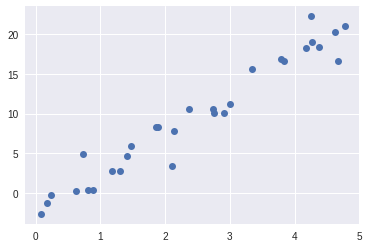

In [2]:
def toy_data():
    x = np.random.uniform(0, 5, 30)
    y = 5 * x - 3 + np.random.normal(0, 2, 30)
    return x, y
x_np, y_np = toy_data()

plt.plot(x_np, y_np, "o")

## make model
We build statistical model as below.

$$
\begin{align}
a \sim N(0, 10) \\
b \sim N(0, 10) \\
y \sim N(ax+b, 2) \\
\end{align}
$$

We want to know the parameters $a$ and $b$ through posterior $p(\cdot \mid x, y)$ from MCMC.

In [3]:
x = tf.convert_to_tensor(
    x_np,
    dtype=tf.float32
)

y = tf.convert_to_tensor(
    y_np,
    dtype=tf.float32
)


Root = tfd.JointDistributionCoroutine.Root
def model():
    a = yield Root(tfd.Normal(loc=0, scale=10.))
    b = yield Root(tfd.Normal(loc=0, scale=10.))
    y = yield tfd.Normal(loc=a * x + b, scale=tf.constant(2.0))



## joint distribution
First, we prepare joint distribution $p(y,a,b\mid x)$. (Note, $x$ is given by out of model.)

In [4]:
joint = tfd.JointDistributionCoroutine(model)
sample = joint.sample()

In [5]:
sample

(<tf.Tensor: id=26, shape=(), dtype=float32, numpy=5.6546383>,
 <tf.Tensor: id=51, shape=(), dtype=float32, numpy=0.31189847>,
 <tf.Tensor: id=77, shape=(30,), dtype=float32, numpy=
 array([25.134127 , 16.945278 ,  1.7397578,  3.467657 , 18.627796 ,
        20.363176 ,  6.232394 , -0.8954295, 19.861036 ,  9.31983  ,
         5.173567 ,  9.215877 , 21.277885 ,  1.5533347,  5.496046 ,
        19.356524 , 28.877434 ,  6.1254034, -3.7839017, 24.558357 ,
        25.708015 , 16.052725 , 15.992117 , 19.334011 , 10.766196 ,
        24.530191 , 12.492117 ,  9.475194 , 26.226992 ,  1.592738 ],
       dtype=float32)>)

## plot before training
That initial model can generate samples $a, b, y$. (However it does not match to data.)

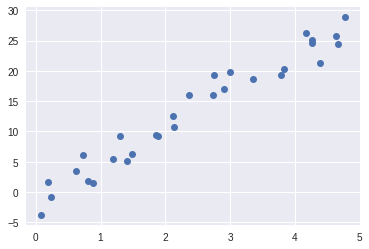

In [6]:
plt.plot(x.numpy(), sample[-1].numpy(), "o")

## likelihood
A generated sample likelihood can be caluclated each data point.

In [7]:
joint.log_prob(sample)

<tf.Tensor: id=115, shape=(30,), dtype=float32, numpy=
array([ -8.277493 ,  -8.221734 ,  -9.475067 ,  -8.234814 ,  -8.262238 ,
        -8.547427 ,  -8.965708 ,  -9.013991 ,  -9.039732 ,  -8.551022 ,
        -9.443696 ,  -8.62281  , -10.0297575,  -9.994436 ,  -8.507306 ,
        -9.7459   ,  -8.516852 ,  -8.572928 , -10.799183 ,  -8.218836 ,
        -8.29117  ,  -8.223557 ,  -8.871852 ,  -8.91931  ,  -8.539169 ,
        -8.812513 ,  -8.222011 ,  -8.44175  ,  -8.872479 ,  -8.223422 ],
      dtype=float32)>

## posterior distribution
MCMC need unnormalized posterior distribution model to calculate energy.

It is maked easily. We have joint distributon $p(y,a,b\mid x)$, so we give this distributon know data $x, y$.
The joint distribution is given $x$ model, therefore we keed to give y to `joint.log_prob`.
The $a$ and $b$ is given through `unnormalized_log_posterior` function lazyly.

In [8]:
def unnormalized_log_posterior(a, b):
    return tf.reduce_mean(joint.log_prob([a, b, y]))

## MCMC
We use popular MCMC method "NUTS" which kind of gradient MCMC.

In [10]:
kernel = tfp.mcmc.NoUTurnSampler(
      target_log_prob_fn=unnormalized_log_posterior,
      step_size=0.1,
)

@tf.function()
def run_chain():
    init_state = list(joint.sample()[:-1]) # a, b
    chains_states, kernels_results = tfp.mcmc.sample_chain(
        num_results=1000,
        num_burnin_steps=300,
        current_state=init_state,
        kernel=kernel
    )
    return chains_states, kernels_results

# Sample from posterior distribution and get diagnostic
import time
start = time.time()
chain_states, kernel_results = run_chain()
print(time.time()-start)

/home/sano/anaconda3/envs/COM/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


24.776576042175293


## result
A `chain_states` have posterior of $a$ and $b$ with MCMC sampler.

In [11]:
a, b = (
    chain_states[0],
    chain_states[1],
)

(array([  8.,   9.,  41., 145., 255., 261., 162.,  79.,  28.,  12.]),
 array([0.19298153, 1.0866332 , 1.9802849 , 2.8739367 , 3.7675884 ,
        4.66124   , 5.5548916 , 6.4485435 , 7.342195  , 8.2358465 ,
        9.1294985 ], dtype=float32),
 <a list of 10 Patch objects>)

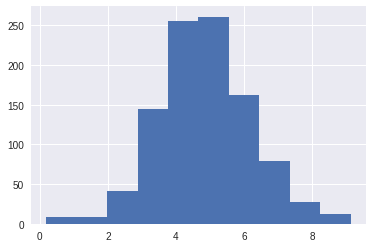

In [12]:
plt.hist(a)

(array([  8.,  16.,  49., 104., 192., 222., 224., 120.,  47.,  18.]),
 array([-14.505614  , -12.321621  , -10.137628  ,  -7.9536347 ,
         -5.7696414 ,  -3.585648  ,  -1.4016548 ,   0.78233844,
          2.9663317 ,   5.150325  ,   7.334318  ], dtype=float32),
 <a list of 10 Patch objects>)

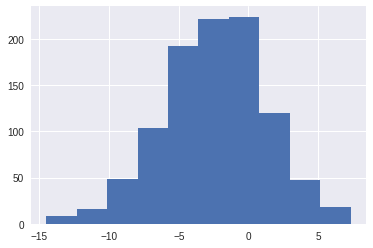

In [13]:
plt.hist(b)

## EAP estimation
We have posterior $p(a \mid x, y)$ and $p(b \mid x, y)$, therefore we can get $\mathbb E _ {p(a \mid x, y)}[a]$ and $\mathbb E _ {p(b \mid x, y)}[b]$ parameters. This is called EAP estimation.

In [14]:
a_mean = tf.reduce_mean(a)
b_mean = tf.reduce_mean(b)

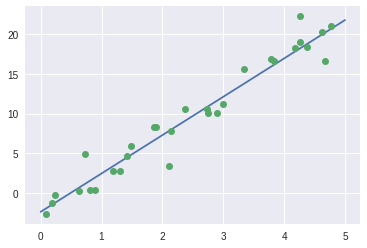

In [15]:
x_new = tf.convert_to_tensor(np.linspace(0, 5, 100), dtype=tf.float32)

y_new = a_mean * x_new + b_mean

plt.plot(x_new, y_new)
plt.plot(x, y, "o")

## Bayes prediction distribution
We can caluclate bayes predictive distribution.

$$
p(y _ {new} \mid x _ {new}, x, y) = \int _ {a, b} p(y _ {new}\mid x _ {new}, a, b)p(a, b \mid x, y)dadb
$$

We use montecalro sampler represented as below.

$$
p(y _ {new} \mid x _ {new}, x, y) \sim \frac{1}{N}\sum _ {a _ i, b _ i} ^ N p(y _ {new}\mid x _ {new}, a _ i, b _ i)
$$

It is apporoximation of "the expected value of the statistical model $p(y _ {new}\mid x _ {new}, a _ i, b _ i)$ by parameter's posterior".

In [18]:
def statistical_model(a, b):
    return tfd.Normal(
        loc=tf.expand_dims(a, axis=0) * tf.expand_dims(x_new, axis=1) + tf.expand_dims(b, axis=0),
        scale=2.0
    ).sample()

samples = statistical_model(a, b)

In [19]:
samples.shape

TensorShape([100, 1000])

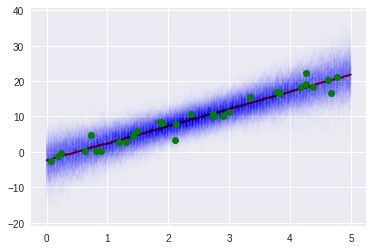

In [22]:
y_expected = tf.reduce_mean(samples, axis=1)

plt.plot(x_new, y_expected, "r")
plt.plot(x_new, samples, "b", alpha=0.003 )
plt.plot(x, y, "og")

In [25]:
def statistical_model(a, b):
    return tf.expand_dims(a, axis=0) * tf.expand_dims(x_new, axis=1) + tf.expand_dims(b, axis=0),

samples = statistical_model(a, b)

ValueError: x and y must have same first dimension, but have shapes (100,) and (1, 1000)

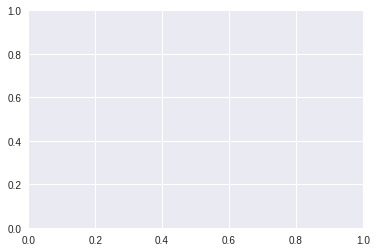

In [24]:
y_expected = tf.reduce_mean(samples, axis=1)

plt.plot(x_new, y_expected, "r")
plt.plot(x_new, samples, "b", alpha=0.003 )
plt.plot(x, y, "og")